# CADJPY/NZDJPY Real-Time Pairs Trading Monitor

## Overview
This notebook monitors the CADJPY/NZDJPY forex pair in real-time, calculating z-scores and generating trading signals based on the statistical analysis performed in the main pairs trading strategy.

### Key Features:
- 📊 **Real-time data download** from Yahoo Finance
- 🧮 **Automated calculations** of hedge ratio, spread, and z-score
- 🚨 **Trading alerts** when z-score approaches ±1 thresholds
- 💰 **Position sizing recommendations** based on signal strength

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Configure display options
warnings.filterwarnings('ignore')
# plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("🔧 Libraries imported successfully!")
print(f"📅 Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 Libraries imported successfully!
📅 Current time: 2025-08-07 17:53:52


In [2]:
# Configuration parameters
PAIR1 = 'CADJPY=X'
PAIR2 = 'NZDJPY=X'
LOOKBACK_DAYS = 1460  # ~4 years of data
ALERT_THRESHOLD = 0.8  # Alert when z-score approaches ±1
SIGNAL_THRESHOLD = 1.0  # Trading signal threshold
STRONG_SIGNAL_THRESHOLD = 2.0  # Strong trading signal

print("⚙️ Configuration:")
print(f"   📈 Primary Pair: {PAIR1}")
print(f"   📉 Secondary Pair: {PAIR2}")
print(f"   📅 Lookback Period: {LOOKBACK_DAYS} days")
print(f"   ⚠️ Alert Threshold: ±{ALERT_THRESHOLD}")
print(f"   🎯 Signal Threshold: ±{SIGNAL_THRESHOLD}")
print(f"   🔥 Strong Signal: ±{STRONG_SIGNAL_THRESHOLD}")

⚙️ Configuration:
   📈 Primary Pair: CADJPY=X
   📉 Secondary Pair: NZDJPY=X
   📅 Lookback Period: 1460 days
   ⚠️ Alert Threshold: ±0.8
   🎯 Signal Threshold: ±1.0
   🔥 Strong Signal: ±2.0


In [3]:
# Download fresh data from Yahoo Finance
def download_forex_data(pair1, pair2, lookback_days):
    """Download and clean forex data"""
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)
        
        print(f"📥 Downloading data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
        
        # Download data
        data = yf.download([pair1, pair2], 
                          start=start_date.strftime('%Y-%m-%d'), 
                          end=end_date.strftime('%Y-%m-%d'),
                          progress=False)
        
        # Check if data was downloaded successfully
        if data.empty:
            print("❌ No data downloaded - possibly invalid tickers or no market data available")
            return None
        
        # Extract Close prices and clean
        if len(data.columns.levels) > 1:  # Multi-index columns
            cadjpy = data['Close'][pair1].dropna()
            nzdjpy = data['Close'][pair2].dropna()
        else:
            cadjpy = data['Close'].dropna()
            nzdjpy = data['Close'].dropna()
        
        # Create aligned dataframe
        forex_data = pd.DataFrame({
            'CADJPY': cadjpy,
            'NZDJPY': nzdjpy
        }).dropna()
        
        # Check if we have any valid data after cleaning
        if forex_data.empty:
            print("❌ No valid data after cleaning - check ticker symbols or date range")
            return None
        
        print(f"✅ Successfully downloaded {len(forex_data)} data points")
        return forex_data
        
    except Exception as e:
        print(f"❌ Error downloading data: {e}")
        return None

# Download current data
data = download_forex_data(PAIR1, PAIR2, LOOKBACK_DAYS)

if data is not None and not data.empty:
    # Check for valid dates before formatting
    if pd.notna(data.index.min()) and pd.notna(data.index.max()):
        print(f"\n📊 Data Summary:")
        print(f"   Date Range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")
        print(f"   Total Days: {len(data)}")
        print(f"\n📈 Latest Prices:")
        print(f"   CADJPY: {data['CADJPY'].iloc[-1]:.4f}")
        print(f"   NZDJPY: {data['NZDJPY'].iloc[-1]:.4f}")
        
        # Display last 5 days
        print("\n📅 Last 5 trading days:")
        print(data.tail().round(4))
    else:
        print("❌ Data contains invalid dates - unable to process")
        data = None
else:
    print("❌ Failed to download data. Please check your internet connection and ticker symbols.")
    print("💡 Note: Markets might be closed or tickers might be incorrect.")
    print(f"   Trying to download: {PAIR1} and {PAIR2}")
    data = None

📥 Downloading data from 2021-08-08 to 2025-08-07
YF.download() has changed argument auto_adjust default to True
✅ Successfully downloaded 1040 data points

📊 Data Summary:
   Date Range: 2021-08-09 to 2025-08-06
   Total Days: 1040

📈 Latest Prices:
   CADJPY: 107.1400
   NZDJPY: 87.1750

📅 Last 5 trading days:
             CADJPY  NZDJPY
Date                       
2025-07-31  107.927  88.136
2025-08-01  108.797  88.750
2025-08-04  106.930  87.119
2025-08-05  106.601  86.836
2025-08-06  107.140  87.175


In [4]:
# Test for cointegration
if data is not None:
    cadjpy = data['CADJPY']
    nzdjpy = data['NZDJPY']
    
    # Perform cointegration test
    coint_score, p_value, critical_values = coint(cadjpy, nzdjpy)
    
    print("🧪 Cointegration Test Results:")
    print("=" * 40)
    print(f"Test Statistic: {coint_score:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Critical Values:")
    print(f"  1%: {critical_values[0]:.4f}")
    print(f"  5%: {critical_values[1]:.4f}")
    print(f"  10%: {critical_values[2]:.4f}")
    
    # Interpretation
    if p_value < 0.01:
        print("\n✅ HIGHLY COINTEGRATED (p < 0.01) - Strong pairs trading candidate")
        cointegration_status = "Strong"
    elif p_value < 0.05:
        print("\n✅ COINTEGRATED (p < 0.05) - Good pairs trading candidate")
        cointegration_status = "Good"
    elif p_value < 0.10:
        print("\n⚠️ WEAKLY COINTEGRATED (p < 0.10) - Proceed with caution")
        cointegration_status = "Weak"
    else:
        print("\n❌ NOT COINTEGRATED (p >= 0.10) - Not suitable for pairs trading")
        cointegration_status = "None"

🧪 Cointegration Test Results:
Test Statistic: -3.3724
P-value: 0.0455
Critical Values:
  1%: -3.9070
  5%: -3.3420
  10%: -3.0485

✅ COINTEGRATED (p < 0.05) - Good pairs trading candidate


In [ ]:
# Calculate regression parameters and spread
if data is not None:
    # Perform OLS regression: NZDJPY = α + β * CADJPY + ε
    cadjpy_with_const = sm.add_constant(cadjpy)
    model = sm.OLS(nzdjpy, cadjpy_with_const).fit()
    
    # Extract parameters
    hedge_ratio = model.params['CADJPY']
    intercept = model.params['const']
    r_squared = model.rsquared
    
    print("📊 Regression Analysis:")
    print("=" * 35)
    print(f"Hedge Ratio (β): {hedge_ratio:.4f}")
    print(f"Intercept (α): {intercept:.4f}")
    print(f"R-squared: {r_squared:.4f} ({r_squared*100:.2f}%)")
    print(f"F-statistic: {model.fvalue:.2f}")
    print(f"P-value (F-test): {model.f_pvalue:.2e}")
    
    # Calculate spread
    spread = nzdjpy - hedge_ratio * cadjpy
    spread_mean = spread.mean()
    spread_std = spread.std()
    
    print(f"\n📈 Spread Statistics:")
    print(f"Mean: {spread_mean:.4f}")
    print(f"Std Dev: {spread_std:.4f}")
    print(f"Current: {spread.iloc[-1]:.4f}")
    print(f"Min: {spread.min():.4f}")
    print(f"Max: {spread.max():.4f}")
    
    # Store for later use
    current_spread = spread.iloc[-1]

📊 Regression Analysis:
Hedge Ratio (β): 0.5989
Intercept (α): 24.0037
R-squared: 0.8631 (86.31%)
F-statistic: 6542.59
P-value (F-test): 0.00e+00

📈 Spread Statistics:
Mean: 24.0037
Std Dev: 1.7665
Current: 23.0130
Min: 17.8324
Max: 28.5593


In [6]:
# Calculate Z-Score and generate signals
if data is not None:
    # Calculate z-score of spread
    zscore_series = (spread - spread_mean) / spread_std
    current_zscore = zscore_series.iloc[-1]
    
    print("🎯 Z-Score Analysis:")
    print("=" * 30)
    print(f"Current Z-Score: {current_zscore:.4f}")
    print(f"Z-Score Mean: {zscore_series.mean():.4f}")
    print(f"Z-Score Std: {zscore_series.std():.4f}")
    print(f"Z-Score Min: {zscore_series.min():.4f}")
    print(f"Z-Score Max: {zscore_series.max():.4f}")
    
    # Recent z-score trend (last 5 days)
    print(f"\n📅 Recent Z-Score Trend (last 5 days):")
    recent_zscores = zscore_series.tail(5)
    for date, zscore_val in recent_zscores.items():
        print(f"   {date.strftime('%Y-%m-%d')}: {zscore_val:.4f}")
    
    # Calculate percentile
    current_percentile = (zscore_series <= current_zscore).mean() * 100
    print(f"\n📊 Current Z-Score Percentile: {current_percentile:.1f}%")

🎯 Z-Score Analysis:
Current Z-Score: -0.5608
Z-Score Mean: 0.0000
Z-Score Std: 1.0000
Z-Score Min: -3.4935
Z-Score Max: 2.5788

📅 Recent Z-Score Trend (last 5 days):
   2025-07-31: -0.2836
   2025-08-01: -0.2310
   2025-08-04: -0.5214
   2025-08-05: -0.5700
   2025-08-06: -0.5608

📊 Current Z-Score Percentile: 27.4%


In [7]:
# Generate trading signals and alerts
def generate_trading_alert(zscore, alert_threshold=0.8, signal_threshold=1.0, strong_threshold=2.0):
    """Generate trading alerts based on z-score"""
    
    print("\n🚨 TRADING SIGNAL ANALYSIS")
    print("=" * 50)
    print(f"📊 Current Z-Score: {zscore:.4f}")
    print("-" * 30)
    
    # Strong signals (immediate action recommended)
    if zscore >= strong_threshold:
        print(f"🔴 STRONG SHORT SIGNAL! Z-score = {zscore:.4f}")
        print(f"   📉 Spread is EXTREMELY overvalued")
        print(f"   💡 RECOMMENDATION: Short NZDJPY, Long CADJPY")
        print(f"   🎯 Target: Mean reversion to {spread_mean:.4f}")
        signal_type = "STRONG_SHORT"
        
    elif zscore <= -strong_threshold:
        print(f"🟢 STRONG LONG SIGNAL! Z-score = {zscore:.4f}")
        print(f"   📈 Spread is EXTREMELY undervalued")
        print(f"   💡 RECOMMENDATION: Long NZDJPY, Short CADJPY")
        print(f"   🎯 Target: Mean reversion to {spread_mean:.4f}")
        signal_type = "STRONG_LONG"
        
    # Regular signals
    elif zscore >= signal_threshold:
        print(f"🟠 SHORT SIGNAL: Z-score = {zscore:.4f}")
        print(f"   📉 Spread is overvalued")
        print(f"   💡 Consider shorting the spread")
        signal_type = "SHORT"
        
    elif zscore <= -signal_threshold:
        print(f"🟡 LONG SIGNAL: Z-score = {zscore:.4f}")
        print(f"   📈 Spread is undervalued")
        print(f"   💡 Consider going long the spread")
        signal_type = "LONG"
        
    # Alert zone (approaching signals)
    elif abs(zscore) >= alert_threshold:
        direction = "SHORT" if zscore > 0 else "LONG"
        print(f"⚠️  ALERT: APPROACHING {direction} SIGNAL!")
        print(f"   🔔 Z-score = {zscore:.4f} (threshold ±{alert_threshold})")
        print(f"   👀 Monitor closely for entry opportunity")
        signal_type = "ALERT"
        
    # Neutral zone
    else:
        print(f"😴 NEUTRAL: Z-score = {zscore:.4f}")
        print(f"   📊 Spread is within normal range")
        print(f"   🔍 No immediate action required")
        signal_type = "NEUTRAL"
    
    return signal_type

# Generate current signal
if data is not None:
    signal = generate_trading_alert(current_zscore, ALERT_THRESHOLD, SIGNAL_THRESHOLD, STRONG_SIGNAL_THRESHOLD)


🚨 TRADING SIGNAL ANALYSIS
📊 Current Z-Score: -0.5608
------------------------------
😴 NEUTRAL: Z-score = -0.5608
   📊 Spread is within normal range
   🔍 No immediate action required


In [8]:
# Position sizing recommendations
if data is not None and abs(current_zscore) >= ALERT_THRESHOLD:
    
    print("\n💰 POSITION SIZING RECOMMENDATIONS")
    print("=" * 45)
    
    # Calculate position multiplier based on z-score magnitude
    base_multiplier = min(abs(current_zscore), 3.0) / 3.0  # Cap at 3x
    risk_factor = 0.02  # 2% risk per trade (adjust as needed)
    
    print(f"📊 Position Analysis:")
    print(f"   Hedge Ratio: {hedge_ratio:.4f}")
    print(f"   Signal Strength: {base_multiplier:.2f}x")
    print(f"   Risk Factor: {risk_factor*100:.1f}% per trade")
    
    if current_zscore > 0:  # Short signal
        print(f"\n📉 SHORT SPREAD POSITION:")
        print(f"   • Short 1.00 unit NZDJPY")
        print(f"   • Long {hedge_ratio:.4f} units CADJPY")
        print(f"   • Position Size Multiplier: {base_multiplier:.2f}x")
        
    else:  # Long signal
        print(f"\n📈 LONG SPREAD POSITION:")
        print(f"   • Long 1.00 unit NZDJPY")
        print(f"   • Short {hedge_ratio:.4f} units CADJPY")
        print(f"   • Position Size Multiplier: {base_multiplier:.2f}x")
    
    # Risk management
    stop_loss_zscore = current_zscore + (2.0 if current_zscore > 0 else -2.0)
    take_profit_zscore = 0.0  # Target mean reversion
    
    print(f"\n🛡️ Risk Management:")
    print(f"   Stop Loss Z-Score: {stop_loss_zscore:.2f}")
    print(f"   Take Profit Z-Score: {take_profit_zscore:.2f}")
    print(f"   Expected Hold Time: 2-20 trading days")

elif data is not None:
    print(f"\n💤 No position recommendations at current z-score: {current_zscore:.4f}")


💤 No position recommendations at current z-score: -0.5608


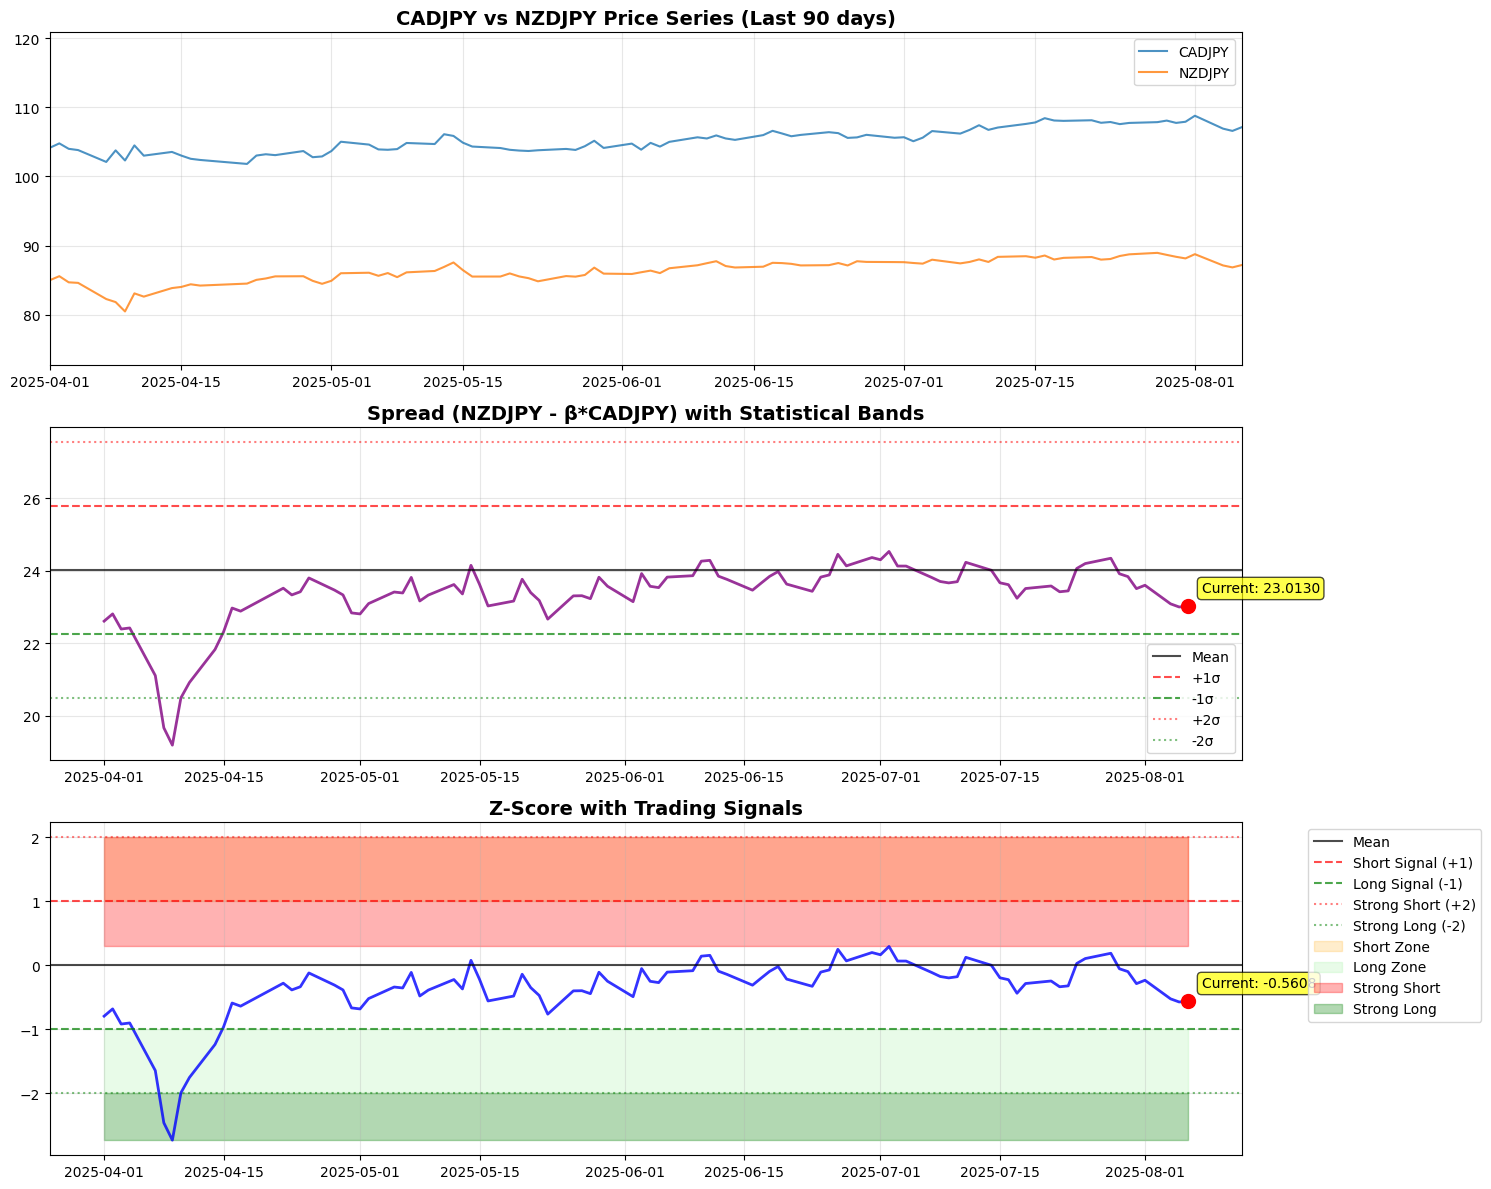


📋 SUMMARY TABLE
         Metric    Value
 Current CADJPY 107.1400
 Current NZDJPY  87.1750
    Hedge Ratio   0.5989
 Current Spread  23.0130
    Spread Mean  24.0037
     Spread Std   1.7665
Current Z-Score  -0.5608
    Signal Type  NEUTRAL


In [9]:
# Visualization of current situation
if data is not None:
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Price series
    axes[0].plot(data.index, data['CADJPY'], label='CADJPY', linewidth=1.5, alpha=0.8)
    axes[0].plot(data.index, data['NZDJPY'], label='NZDJPY', linewidth=1.5, alpha=0.8)
    axes[0].set_title('CADJPY vs NZDJPY Price Series (Last 90 days)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(data.index[-90:].min(), data.index.max())  # Last 90 days
    
    # Plot 2: Spread
    recent_spread = spread.tail(90)  # Last 90 days
    axes[1].plot(recent_spread.index, recent_spread, color='purple', linewidth=2, alpha=0.8)
    axes[1].axhline(spread_mean, color='black', linestyle='-', alpha=0.7, label='Mean')
    axes[1].axhline(spread_mean + spread_std, color='red', linestyle='--', alpha=0.7, label='+1σ')
    axes[1].axhline(spread_mean - spread_std, color='green', linestyle='--', alpha=0.7, label='-1σ')
    axes[1].axhline(spread_mean + 2*spread_std, color='red', linestyle=':', alpha=0.5, label='+2σ')
    axes[1].axhline(spread_mean - 2*spread_std, color='green', linestyle=':', alpha=0.5, label='-2σ')
    
    # Mark current point
    axes[1].scatter(recent_spread.index[-1], current_spread, color='red', s=100, zorder=5)
    axes[1].annotate(f'Current: {current_spread:.4f}', 
                    xy=(recent_spread.index[-1], current_spread),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    axes[1].set_title('Spread (NZDJPY - β*CADJPY) with Statistical Bands', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Z-Score
    recent_zscore = zscore_series.tail(90)  # Last 90 days
    color_map = ['green' if z <= -1 else 'red' if z >= 1 else 'blue' for z in recent_zscore]
    
    axes[2].plot(recent_zscore.index, recent_zscore, color='blue', linewidth=2, alpha=0.8)
    axes[2].axhline(0, color='black', linestyle='-', alpha=0.7, label='Mean')
    axes[2].axhline(1, color='red', linestyle='--', alpha=0.7, label='Short Signal (+1)')
    axes[2].axhline(-1, color='green', linestyle='--', alpha=0.7, label='Long Signal (-1)')
    axes[2].axhline(2, color='red', linestyle=':', alpha=0.5, label='Strong Short (+2)')
    axes[2].axhline(-2, color='green', linestyle=':', alpha=0.5, label='Strong Long (-2)')
    
    # Fill signal zones
    axes[2].fill_between(recent_zscore.index, 1, 2, alpha=0.2, color='orange', label='Short Zone')
    axes[2].fill_between(recent_zscore.index, -1, -2, alpha=0.2, color='lightgreen', label='Long Zone')
    axes[2].fill_between(recent_zscore.index, 2, recent_zscore.max(), alpha=0.3, color='red', label='Strong Short')
    axes[2].fill_between(recent_zscore.index, -2, recent_zscore.min(), alpha=0.3, color='green', label='Strong Long')
    
    # Mark current point
    axes[2].scatter(recent_zscore.index[-1], current_zscore, color='red', s=100, zorder=5)
    axes[2].annotate(f'Current: {current_zscore:.4f}', 
                    xy=(recent_zscore.index[-1], current_zscore),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    axes[2].set_title('Z-Score with Trading Signals', fontsize=14, fontweight='bold')
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Current CADJPY', 'Current NZDJPY', 'Hedge Ratio', 'Current Spread', 
                  'Spread Mean', 'Spread Std', 'Current Z-Score', 'Signal Type'],
        'Value': [f"{data['CADJPY'].iloc[-1]:.4f}", f"{data['NZDJPY'].iloc[-1]:.4f}", 
                 f"{hedge_ratio:.4f}", f"{current_spread:.4f}", 
                 f"{spread_mean:.4f}", f"{spread_std:.4f}", 
                 f"{current_zscore:.4f}", signal]
    })
    
    print("\n📋 SUMMARY TABLE")
    print("=" * 30)
    print(summary_stats.to_string(index=False))

In [11]:
# Export results to CSV for tracking
if data is not None:
    
    # Create results summary
    results_summary = pd.DataFrame({
        'timestamp': [datetime.now()],
        'cadjpy_price': [data['CADJPY'].iloc[-1]],
        'nzdjpy_price': [data['NZDJPY'].iloc[-1]],
        'hedge_ratio': [hedge_ratio],
        'spread': [current_spread],
        'spread_mean': [spread_mean],
        'spread_std': [spread_std],
        'zscore': [current_zscore],
        'signal_type': [signal],
        'cointegration_pvalue': [p_value],
        'r_squared': [r_squared]
    })
    
    # # Save to CSV
    # output_file = 'cadjpy_nzdjpy_monitor_results.csv'
    
    # try:
    #     # Append to existing file or create new one
    #     existing_data = pd.read_csv(output_file)
    #     combined_data = pd.concat([existing_data, results_summary], ignore_index=True)
    #     combined_data.to_csv(output_file, index=False)
    #     print(f"✅ Results appended to {output_file}")
    # except FileNotFoundError:
    #     results_summary.to_csv(output_file, index=False)
    #     print(f"✅ Results saved to new file: {output_file}")
    
    # print(f"\n📊 Current analysis saved with timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Display the latest entry
    print("\n📄 Latest Record:")
    print(results_summary.round(4).to_string(index=False))


📄 Latest Record:
                 timestamp  cadjpy_price  nzdjpy_price  hedge_ratio  spread  spread_mean  spread_std  zscore signal_type  cointegration_pvalue  r_squared
2025-08-07 17:58:25.857178        107.14        87.175       0.5989  23.013      24.0037      1.7665 -0.5608     NEUTRAL                0.0455     0.8631


## 🔄 Next Steps

### For Continuous Monitoring:
1. **Run this notebook** regularly (e.g., daily before market open)
2. **Check the CSV file** for historical tracking of signals
3. **Set up alerts** based on the signal types generated

### For Trading Implementation:
1. **Validate signals** with additional technical analysis
2. **Consider market conditions** and news events
3. **Implement proper risk management** with stop-losses
4. **Track performance** of executed trades

### Signal Interpretation:
- 🟢 **STRONG_LONG**: High probability mean-reversion opportunity (Z < -2)
- 🔴 **STRONG_SHORT**: High probability mean-reversion opportunity (Z > +2)
- 🟡 **LONG**: Moderate signal strength (Z < -1)
- 🟠 **SHORT**: Moderate signal strength (Z > +1)
- ⚠️ **ALERT**: Approaching signal threshold (|Z| > 0.8)
- 😴 **NEUTRAL**: No action required (|Z| < 0.8)

---
**⚠️ Disclaimer**: This is for educational purposes only. Past performance does not guarantee future results. Always conduct your own analysis and risk management before trading.